<a href="https://colab.research.google.com/github/ar-ushi/Face-Mask-Detection/blob/master/FaceMaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id}  -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Pre-Processing**


In [ ]:
import os

#setting directory path for dataset
os.chdir("/content/drive/My Drive/Face-Mask-Detection")
Dataset = "data"
Data_dir = os.listdir(Dataset)
print(Data_dir)

['without_mask', 'with_mask']


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

img_rows,img_cols = 112,112

images = []
labels = [] 

for category in Data_dir:
  folder_path = os.path.join(Dataset,category)
  for img in os.listdir(folder_path):
    img_path = os.path.join(folder_path,img)
    img = cv2.imread(img_path)

    try:
      #converting image into gray scale
      grayscale_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

      #resizing gray scaled image into size 56x56
      resized_img =  cv2.resize(grayscale_img,(img_rows,img_cols))
      images.append(resized_img)
      labels.append(category)
    #Exception Handling
    except Exception as e:
      print("Exception Details : " + e)
images = np.array(images) /255.0
images = np.reshape(images,(images.shape[0],img_rows,img_cols,1))

#performing one hot encoding
lb = LabelBinarizer() 
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels = np.array(labels)

(train_X,test_X,train_y,test_y) = train_test_split(images,labels,test_size = 0.25,random_state= 0)




**Building CNN Classification Model**


In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D

num_classes = 2
batch_size = 32

#Building CNN model via Sequential API

model = Sequential()

#First Layer
model.add(Conv2D(64,(3,3), input_shape = (img_rows,img_cols,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

#Second Layer
model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

#Flatten and Dropout Layer
model.add(Flatten())
model.add(Dropout(0.5))

#Softmax Classifier
model.add(Dense(64,activation = "relu"))
model.add(Dense(num_classes,activation= "softmax"))

print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 110, 110, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 53, 53, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

**Plotting the Model for Deeper Insights**



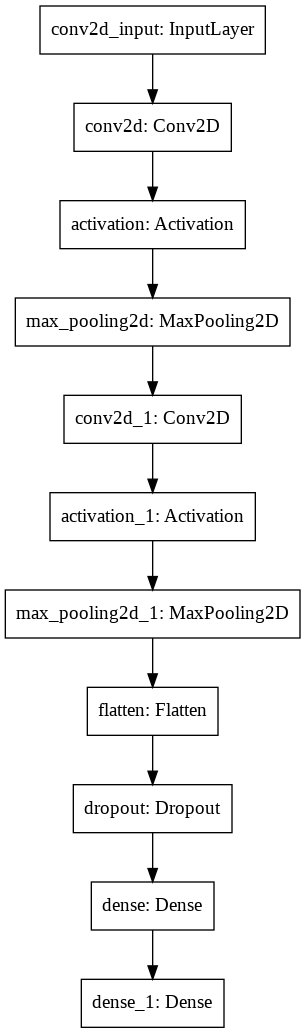

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file="face_mask_detection_model.png")

**Train the Model**

In [ ]:
from keras.optimizers import Adam 
epochs = 50

model.compile(loss= 'categorical_crossentropy',optimizer= Adam(lr=0.001),metrics=['accuracy'])
fitted_model = model.fit(train_X,train_y,epochs = epochs,validation_split=0.25)

Epoch 1/50
25/25 [==============================] - 1s 32ms/step - loss: 0.7272 - accuracy: 0.5517 - val_loss: 0.6446 - val_accuracy: 0.6085
Epoch 2/50
25/25 [==============================] - 1s 24ms/step - loss: 0.5256 - accuracy: 0.7261 - val_loss: 0.4933 - val_accuracy: 0.7946
Epoch 3/50
25/25 [==============================] - 1s 24ms/step - loss: 0.3453 - accuracy: 0.8501 - val_loss: 0.3528 - val_accuracy: 0.8605
Epoch 4/50
25/25 [==============================] - 1s 24ms/step - loss: 0.2230 - accuracy: 0.9134 - val_loss: 0.5720 - val_accuracy: 0.7984
Epoch 5/50
25/25 [==============================] - 1s 24ms/step - loss: 0.1948 - accuracy: 0.9251 - val_loss: 0.5301 - val_accuracy: 0.7829
Epoch 6/50
25/25 [==============================] - 1s 24ms/step - loss: 0.1632 - accuracy: 0.9457 - val_loss: 0.2789 - val_accuracy: 0.9070
Epoch 7/50
25/25 [==============================] - 1s 24ms/step - loss: 0.1148 - accuracy: 0.9574 - val_loss: 0.3641 - val_accuracy: 0.8450
Epoch 8/50
25

**Plot the training loss and accuracy**

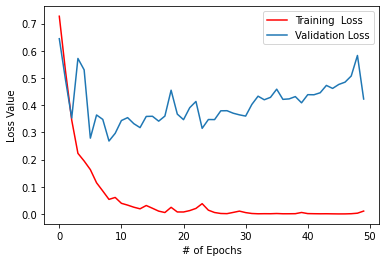

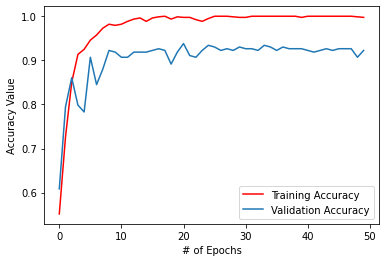

In [ ]:
import matplotlib.pyplot as plt
plt.plot(fitted_model.history['loss'],'r',label = "Training  Loss")
plt.plot(fitted_model.history['val_loss'],label = "Validation Loss")
plt.xlabel("# of Epochs")
plt.ylabel("Loss Value")
plt.legend()
plt.show()

#Plotting Accuracy
plt.plot(fitted_model.history['accuracy'],'r',label = "Training Accuracy")
plt.plot(fitted_model.history['val_accuracy'],label = "Validation Accuracy")
plt.xlabel("# of Epochs")
plt.ylabel("Accuracy Value")
plt.legend()
plt.show()


**Saving the Model**


In [ ]:
model.save("Face_Mask_Model.h5")